# TensorFlow 教程 #06
# CIFAR-10

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/[GitHub中文](https://github.com/Hvass-Labs/TensorFlow-Tutorials-Chinese)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)修订[ZhouGeorge](https://github.com/ZhouGeorge) 

## 警告!

**这份教程使用的TensorFlow的版本不是v1.9，由于PrettyTensor构筑API不再被Google开发者更新和支持。用Keras API更新这份教程需要花费大量精力，特别是 [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)做了相同的工作。**

## 简介

这篇教程介绍了如何创建一个在CIRAR-10数据集上进行图像分类的卷积神经网络。同时也说明了在训练和测试时如何使用不同的网络。

本文基于上一篇教程，你需要了解基本的TensorFlow和附加包Pretty Tensor。其中大量代码和文字与之前教程相似，如果你已经看过可以快速地浏览本文。

## 流程图

下面的图表直接显示了之后实现的卷积神经网络中数据的传递。首先有一个扭曲（distorts）输入图像的预处理层，用来人为地扩大训练集。接着有两个卷积层，两个全连接层和一个softmax分类层。在后面会有更大的图示来显示权重和卷积层的输出，教程 #02 有卷积如何工作的更多细节。

在这种情况下图像是误分类的。图像上有一只狗，但神经网络不确定它是狗还是猫，认为更有可能是猫。

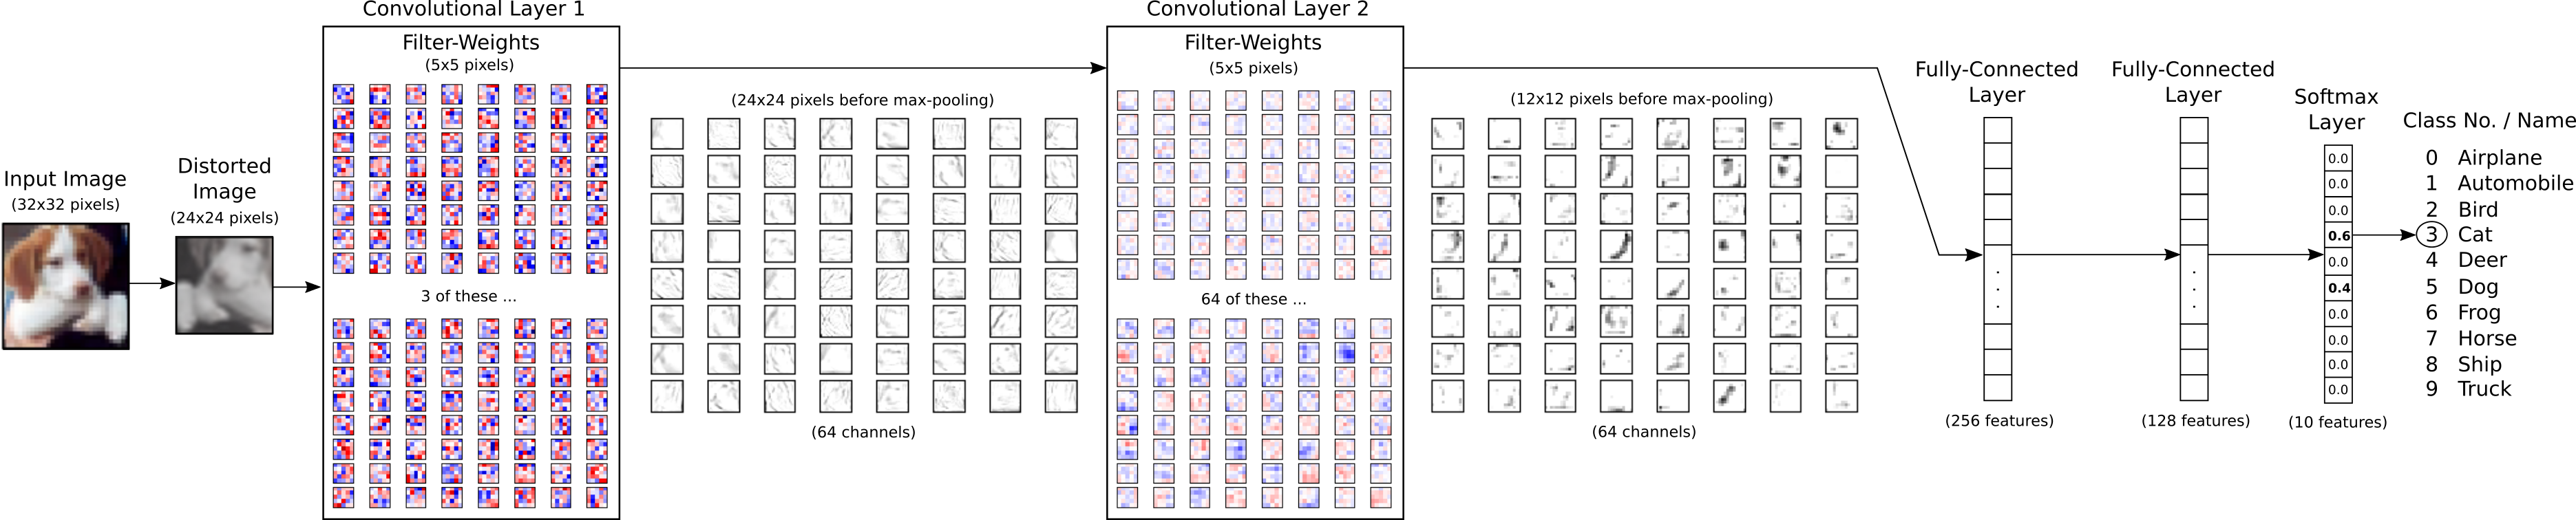

In [1]:
from IPython.display import Image
Image('images/06_network_flowchart.png')

## 导入

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [3]:
tf.__version__

'1.6.0'

PrettyTensor 版本:

In [3]:
pt.__version__

'0.7.4'

## 载入数据

In [4]:
import cifar10

设置电脑上保存数据集的路径。

In [6]:
# cifar10.data_path = "data/CIFAR-10/"

CIFAR-10数据集大概有163MB，如果给定路径没有找到文件的话，将会自动下载。

In [5]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


载入分类名称。

In [6]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

载入训练集。这个函数返回图像、整形分类号码、以及用One-Hot编码的分类号数组，称为标签。

In [7]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


载入测试集。

In [8]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


现在已经载入了CIFAR-10数据集，它包含60,000张图像以及相关的标签（图像的分类）。数据集被分为两个独立的子集，即训练集和测试集。

In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


### 数据维度

下面的代码中多次用到数据维度。cirfa10模块中已经定义好了这些，因此我们只需要import进来。

In [10]:
from cifar10 import img_size, num_channels, num_classes

图像是32 x 32像素的，但我们将图像裁剪至24 x 24像素。

In [11]:
img_size_cropped = 24

### 用来绘制图片的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [12]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制几张图像来看看数据是否正确

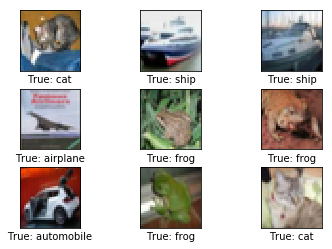

In [13]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

上面像素化的图像是神经网络的输入。如果我们对图像进行平滑处理，可能更易于人眼识别。

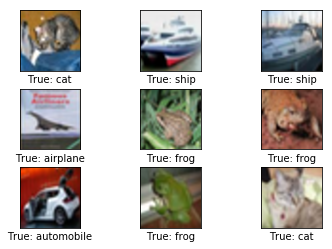

In [15]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow图

TensorFlow的全部目的就是使用一个称之为计算图（computational graph）的东西，它会比直接在Python中进行相同计算量要高效得多。TensorFlow比Numpy更高效，因为TensorFlow了解整个需要运行的计算图，然而Numpy只知道某个时间点上唯一的数学运算。

TensorFlow也能够自动地计算需要优化的变量的梯度，使得模型有更好的表现。这是由于图是简单数学表达式的结合，因此整个图的梯度可以用链式法则推导出来。

TensorFlow还能利用多核CPU和GPU，Google也为TensorFlow制造了称为TPUs（Tensor Processing Units）的特殊芯片，它比GPU更快。

一个TensorFlow图由下面几个部分组成，后面会详细描述：

* 占位符变量（Placeholder）用来改变图的输入。
* 模型变量（Model）将会被优化，使得模型表现得更好。
* 模型本质上就是一些数学函数，它根据Placeholder和模型的输入变量来计算一些输出。
* 一个cost度量用来指导变量的优化。
* 一个优化策略会更新模型的变量。

另外，TensorFlow图也包含了一些调试状态，比如用TensorBoard打印log数据，本教程不涉及这些。

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，我们每次运行图的时候都可能改变它们。将这个过程称为feeding placeholder变量，后面将会描述这个。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为float32，形状设为`[None, img_size, img_size, num_channels]`代表tensor可能保存着任意数量的图像，每张图像宽高都为`img_size`，有`num_channels`个颜色通道。

In [16]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

接下来我们为输入变量`x`中的图像所对应的真实标签定义placeholder变量。变量的形状是`[None, num_classes]`，这代表着它保存了任意数量的标签，每个标签是长度为`num_classes`的向量，本例中长度为10。

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

我们也可以为class-number提供一个placeholder，但这里用argmax来计算它。这里只是TensorFlow中的一些操作，没有执行什么运算。

In [18]:
y_true_cls = tf.argmax(y_true, axis=1)

### 预处理的帮助函数

下面的帮助函数创建了用来预处理输入图像的TensorFlow计算图。这里并未执行计算，函数只是给TensorFlow计算图添加了节点。

神经网络在训练和测试阶段的预处理方法不同：

* 对于训练来说，输入图像是随机裁剪、水平翻转的，并且用随机值来调整色调、对比度和饱和度。这样就创建了原始输入图像的随机变体，人为地扩充了训练集。后面会显示一些扭曲过的图像样本。

* 对于测试，输入图像根据中心裁剪，其他不作调整。

In [19]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

下面函数中，输入batch中每张图像都调用以上函数。

In [20]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

为了绘制扭曲过的图像，我们为TensorFlow创建预处理graph，后面将会运行它。

In [21]:
distorted_images = pre_process(images=x, training=True)

### 创建主要处理程序的帮助函数

下面的帮助函数创建了卷积神经网络的主要部分。这里使用之前教程描述过的Pretty Tensor。

In [22]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

### 创建神经网络的帮助函数

下面的帮助函数创建了整个神经网络，包含上面定义的预处理以及主要处理模块。

注意，神经网络被编码到'network'变量作用域中。因为我们实际上在TensorFlow图中创建了两个神经网络。像这样指定一个变量作用域，可以在两个神经网络中复用变量，因此训练网络优化过的变量可以在测试网络中复用。

In [23]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### 为训练阶段创建神经网络

首先创建一个保存当前优化迭代次数的TensorFlow变量。在之前的教程中，是使用一个Python变量，但本教程中，我们想用checkpoints中的其他TensorFlow变量来保存。

`trainable=False`表示TensorFlow不会优化此变量。

In [24]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

创建训练用的神经网络。函数 `create_network()`返回`y_pred`和`loss`，但在训练时我们只需用到`loss`函数。

In [25]:
_, loss = create_network(training=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



创建最小化`loss`函数的优化器。同时将`global_step`传给优化器，这样每次迭代它都减一。

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### 创建测试阶段的神经网络

现在创建测试阶段的神经网络。 同样的，`create_network()` 返回输入图像的预测标签 `y_pred`，优化过程也用到 `loss`函数。测试时我们只需要`y_pred`。

In [27]:
y_pred, _ = create_network(training=False)

然后我们计算预测类别号的整形数字。网络的输出`y_pred`是一个10个元素的数组。类别号是数组中最大元素的索引。

In [28]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


然后创建一个布尔向量，用来告诉我们每张图片的真实类别是否与预测类别相同。

In [29]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

上面的计算先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确率。

In [30]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

为了保存神经网络的变量（这样不必再次训练网络就能重载），我们创建一个称为Saver-object的对象，它用来保存及恢复TensorFlow图的所有变量。在这里并未保存什么东西，（保存操作）在后面的`optimize()`函数中完成。

In [31]:
saver = tf.train.Saver()

### 获取权重

下面，我们要绘制神经网络的权重。当使用Pretty Tensor来创建网络时，层的所有变量都是由Pretty Tensoe间接创建的。因此我们要从TensorFlow中获取变量。

我们用`layer_conv1` 和 `layer_conv2`代表两个卷积层。这也叫变量作用域（不要与上面描述的`defaults_scope`混淆了）。PrettyTensor会自动给它为每个层创建的变量命名，因此我们可以通过层的作用域名称和变量名来取得某一层的权重。

函数实现有点笨拙，因为我们不得不用TensorFlow函数`get_variable()`，它是设计给其他用途的，创建新的变量或重用现有变量。创建下面的帮助函数很简单。

In [32]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

借助这个帮助函数我们可以获取变量。这些是TensorFlow的objects。你需要类似的操作来获取变量的内容： `contents = session.run(weights_conv1)` ，下面会提到这个。

In [33]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### 获取layer的输出

同样的，我们还需要获取卷积层的输出。这个函数与上面获取权重的函数有所不同。这里我们找回卷积层输出的最后一个张量。

In [34]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

取得卷积层的输出以便之后绘制。

In [35]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [36]:
session = tf.Session()

### 初始化或恢复变量

训练神经网络会花上很长时间，特别是当你没有GPU的时候。因此我们在训练时保存checkpoints，这样就能在其他时间继续训练（比如晚上），以后也可以不用训练神经网络就用这些来分析结果。

如果你想重新训练神经网络，就需要先删掉这些checkpoints。

这是用来保存checkpoints的文件夹。

In [37]:
save_dir = 'checkpoints/'

如果文件夹不存在则创建。

In [38]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

这是checkpoints的基本文件名，TensorFlow会在后面添加迭代次数等。

In [39]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

试着载入最新的checkpoint。如果checkpoint不存在或改变了TensorFlow图的话，可能会失败并抛出异常。

In [40]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/network4
Failed to restore checkpoint. Initializing variables instead.


### 创建随机训练batch的帮助函数

在训练集中有50,000张图。用这些图像计算模型的梯度会花很多时间。因此，在优化器的每次迭代里只用到了一小部分的图像。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [41]:
train_batch_size = 64

函数从训练集中挑选一个随机的training-batch。

In [42]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### 执行优化迭代的帮助函数

函数用来执行一定数量的优化迭代，以此来逐渐改善网络层的变量。在每次迭代中，会从训练集中选择新的一批数据，然后TensorFlow在这些训练样本上执行优化。每100次迭代会打印出进度。每1000次迭代后会保存一个checkpoint，最后一次迭代完毕也会保存。

In [43]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 用来绘制错误样本的帮助函数

函数用来绘制测试集中被误分类的样本。

In [44]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 绘制混淆（confusion）矩阵的帮助函数

In [45]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### 计算分类的帮助函数

这个函数用来计算图像的预测类别，同时返回一个代表每张图像分类是否正确的布尔数组。

由于计算可能会耗费太多内存，就分批处理。如果你的电脑死机了，试着降低batch-size。

In [46]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [47]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### 计算分类准确率的帮助函数

这个函数计算了给定布尔数组的分类准确率，布尔数组表示每张图像是否被正确分类。比如， `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`。这个函数也返回了正确分类的数量。

In [48]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### 展示性能的帮助函数

函数用来打印测试集上的分类准确率。

为测试集上的所有图片计算分类会花费一段时间，因此我们直接从这个函数里调用上面的函数，这样就不用每个函数都重新计算分类。

In [49]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### 绘制卷积权重的帮助函数

In [50]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制卷积层输出的帮助函数

In [51]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 输入图像变体的样本

为了人为地增加训练用的图像数量，神经网络预处理获取输入图像的随机变体。这让神经网络在识别和分类图像时更加灵活。

这是用来绘制输入图像变体的帮助函数。

In [52]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

帮助函数获取测试集图像以及它的分类号。

In [53]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

从测试集中取一张图像以及它的真实类别。

In [54]:
img, cls = get_test_image(16)

画出图像的9张随机变体。如果你重新运行代码，可能会得到不太一样的结果。

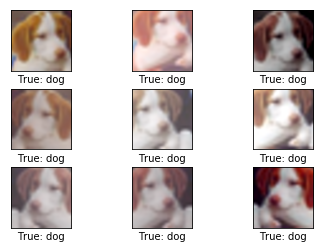

In [55]:
plot_distorted_image(img, cls)

## 执行优化

我的笔记本电脑是4核的，每个2GHz。电脑带有一个GPU，但对TensorFlow来说不太快，因此只用了CPU。在电脑上迭代10,000次大概花了1个小时。本教程中我执行了150,000次优化迭代，共花了15个小时。我让它在夜里以及白天的几个时间段运行。

由于我们在优化过程中保存了checkpoints，重新运行代码时会载入最后的那个checkpoint，所以可以先停止，等晚点再继续执行优化。

In [56]:
if False:
    optimize(num_iterations=1000)

用1066迭代10000次大约用时6分钟，模型比较，很难拟合训练集，不建议过多迭代

In [58]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  35.9%
Global Step:    200, Training Batch Accuracy:  37.5%
Global Step:    300, Training Batch Accuracy:  31.2%
Global Step:    400, Training Batch Accuracy:  43.8%
Global Step:    500, Training Batch Accuracy:  48.4%
Global Step:    600, Training Batch Accuracy:  48.4%
Global Step:    700, Training Batch Accuracy:  48.4%
Global Step:    800, Training Batch Accuracy:  53.1%
Global Step:    900, Training Batch Accuracy:  45.3%
Global Step:   1000, Training Batch Accuracy:  39.1%
Saved checkpoint.
Global Step:   1100, Training Batch Accuracy:  45.3%
Global Step:   1200, Training Batch Accuracy:  54.7%
Global Step:   1300, Training Batch Accuracy:  45.3%
Global Step:   1400, Training Batch Accuracy:  46.9%
Global Step:   1500, Training Batch Accuracy:  42.2%
Global Step:   1600, Training Batch Accuracy:  45.3%
Global Step:   1700, Training Batch Accuracy:  45.3%
Global Step:   1800, Training Batch Accuracy:  59.4%
Global Step:   1900, Trainin

## 结果

在150,000次优化迭代之后，测试集上的分类准确率大约79%-80%。下面画出了一些误分类的图像。其中有一些即使人眼也很难分辨出来，也有一些是合乎情理的错误，比如大型车和卡车，猫与狗，但有些错误就有点奇怪了。

Accuracy on Test-Set: 61.3% (6130 / 10000)
Example errors:


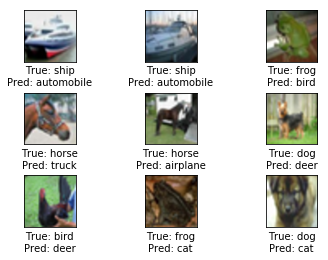

Confusion Matrix:
[712  41  18   4  21   3   1   8  87 105] (0) airplane
[ 18 762   3   5   1   1   4   1  42 163] (1) automobile
[113  34 454  58 112  24  32  63  28  82] (2) bird
[ 37  43  68 364  68  84  30  61  44 201] (3) cat
[ 46  22  44  36 535   9  28 161  25  94] (4) deer
[ 22  25  74 180  61 388   8 107  19 116] (5) dog
[ 21  42  40  62  74  14 581  16  23 127] (6) frog
[ 28  14  17  31  62  25   1 700   9 113] (7) horse
[ 51  60   6   6   3   2   1   3 778  90] (8) ship
[ 24  76   3   2   2   0   1   4  32 856] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [59]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### 卷积权重

下面展示了一些第一个卷积层的权重（或滤波）。共有3个输入通道，因此有三组（数据），你可以改变`input_channel`来改变绘制结果。

权重正值是红的，负值是蓝的。

Min:  -0.64810, Max:   0.56196
Mean: -0.00269, Stdev: 0.16289


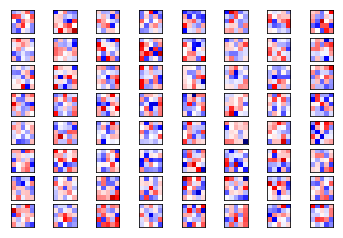

In [60]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

下面展示了一些第二个卷积层的权重（或滤波）。它们比第一个卷积层的权重更接近零，你可以看到比较低的标准差。

Min:  -0.16766, Max:   0.17277
Mean: -0.00126, Stdev: 0.03709


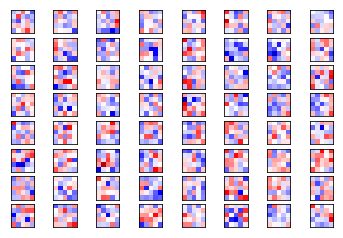

In [61]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### 卷积层的输出

绘制图像的帮助函数。

In [62]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

绘制一张测试集中的图像。未处理的像素图像作为神经网络的输入。

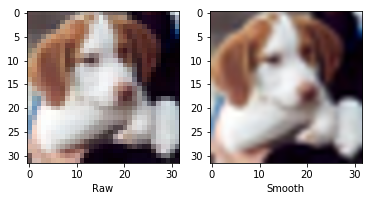

In [63]:
img, cls = get_test_image(16)
plot_image(img)

将原始图像作为神经网络的输入，然后画出第一个卷积层的输出。

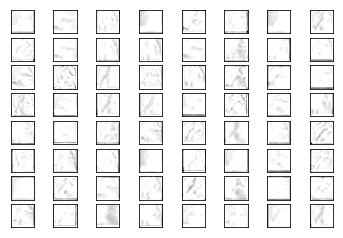

In [64]:
plot_layer_output(output_conv1, image=img)

将同样的图像作为输入，画出第二个卷积层的输出。

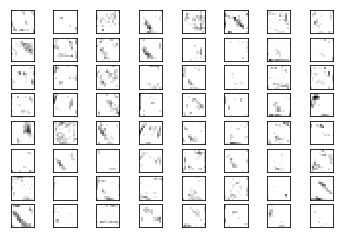

In [65]:
plot_layer_output(output_conv2, image=img)

### 预测的类别标签

获取图像的预测类别标签和类别号。

In [66]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

打印预测类别标签。

In [67]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[ 0.004  0.019  0.02   0.208  0.     0.717  0.001  0.019  0.002  0.01 ]


预测类别标签是长度为10的数组，每个元素代表着神经网络有多大信心认为图像是该类别。

在这个例子中，索引3的值是0.493，5的值为0.490。这表示神经网络相信图像要么是类别3，要么是类别5，即猫或狗。

In [68]:
class_names[3]

'cat'

In [69]:
class_names[5]

'dog'

### 关闭TensorFlow会话

现在我们已经用TensorFlow完成了任务，关闭session，释放资源。

In [69]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## 结论

这篇教程介绍了如何创建一个在CIRAR-10数据集上进行图像分类的卷积神经网络。测试集上的分类准确率大概79-80%。

同时也画出了卷积层的输出，但很难看出神经网络如何分辨并分类图像。需要更好的可视化技巧。

## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Nootbook进行改变之前，可能需要先备份一下。

* 执行10,000次迭代，看看分类准确率如何。将会保存一个checkpoint来储存TensorFlow图的所有变量。
* 再执行100,000次迭代，看看分类准确率有没有提升。然后再执行100,000次。准确率有提升吗，你认为值得这些增加的计算时间吗？
* 试着再预处理阶段改变图像的变体。
* 试着改变神经网络的结构。你可以让神经网络更大或更小。这对训练时间或分类准确率有什么影响？要注意的是，当你改变了神经网络结构时，就无法重新载入checkpoints了。
* 试着在第二个卷积层使用batch-normalization。也试试在俩个层中都删掉它。
* 研究一些CIFAR-10上的[更好的神经网络](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html) ，试着实现它们。
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.